# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (OPTIONAL)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#Conclusions)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pickle

import project_tests as t

%matplotlib inline

In [2]:
df = pd.read_csv('./data/user-item-interactions.csv')
del df['Unnamed: 0']
df['article_id'] = df['article_id'].astype(int)

df.head()

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df_content = pd.read_csv('./data/articles_community.csv')
del df_content['Unnamed: 0']

df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis"> Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

Overview:
 > 1056 user - article interactions in the dataset.
 > 5148 unique non-null users.
 > 714 unique non-null articles.


Missing values:
 > col 'email' has 17 missing values.


Descriptive Statistics:
 > min: 1
 > mean: 8.930846930846931
 > median: 3.0
 > max: 364
 > mode: 1


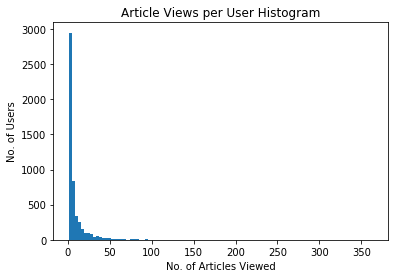

In [4]:
### OVERVIEW SEGMENT
print('Overview:')

# get number of interactions (each row in the dataset represents an interaction)
interactions = df_content.shape[0]
# get number of unique emails (non-null) from dataset
users = df['email'].nunique()
# get number of unique articles (non-null) from dataset
articles = df['article_id'].nunique()

print(' > {} user - article interactions in the dataset.'.format(interactions))
print(' > {} unique non-null users.'.format(users))
print(' > {} unique non-null articles.'.format(articles))
print('\n')


### MISSING DATA SEGMENT
print('Missing values:')

# create series with missing values count by col name (index)
missing_counts = df.isnull().sum()
# get list of col names with at least one missing value
cols_missing_vals = missing_counts[missing_counts > 0].index.values
# print each column and the number of missing values
for col in cols_missing_vals:
    print(' > col \'{}\' has {} missing values.'.format(col, missing_counts[col]))
print('\n')


# DESCRIPTIVE STATISTICS SEGMENT
print('Descriptive Statistics:')

# create dataframe of how many articles each user interacted with
articles_by_user = df.groupby(['email'])['article_id'].count()

print(' > min: {}'.format(articles_by_user.min()))
print(' > mean: {}'.format(articles_by_user.mean()))
print(' > median: {}'.format(articles_by_user.median()))
print(' > max: {}'.format(articles_by_user.max()))
print(' > mode: {}'.format(articles_by_user.mode()[0]))

# plot histogram of number of article interactions by user
plt.hist(articles_by_user, bins=100)
plt.title('Article Views per User Histogram')
plt.xlabel('No. of Articles Viewed')
plt.ylabel('No. of Users')
plt.show()

Most users interacted with multiple articles, but there are some who interacted with the same article multiple times, with the most frequent re-view of 42 times.

In [5]:
# create dataframe with interaction duplicates
dups_df = df[['article_id', 'email']]\
            .groupby(by=['article_id', 'email'], as_index=False)\
            .size()\
            .sort_values(ascending=False)\
            .reset_index()

# rename count column from 0 to 'count'
dups_df.rename({0: 'count'}, axis=1, inplace=True)

# remove any user-article interaction count lower than 2
dups_df = dups_df[dups_df['count'] > 1]
# display top 5
dups_df.head()

,article_id,email,count
0,1170,1588af175b283915f597fc4719cbb2c8621c4fc2,42
1,1170,363cb98a087e4a3eb6890fd1af2d418116f85ff8,41
2,1429,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,35
3,1429,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,35
4,1429,c8afd6f4620184042cc48ca0eba9a657ac89e90e,25


In [6]:
# count views per article for each article and store in a sorted series
article_views = df.groupby(['article_id'], as_index=False)\
                    ['email'].count()\
                    .sort_values(by='email', ascending=False)

# get first item id - article with most views
most_viewed_article_id = article_views.iloc[0, 0]
# get first item value - views the top article has
max_views = article_views.iloc[0, 1]

print('Most viewed article is {} and got {} views.'.format(most_viewed_article_id, max_views))

Most viewed article is 1429 and got 937 views.


#### Data Cleaning: here's where we clean the data seen previously to have a tidy dataset to work with

In [7]:
# remove any rows that have the same article_id - only keep the first
print('`df_content` size before removing duplicates: {}'.format(df_content.shape[0]))
df_content.drop_duplicates(subset=['article_id'], inplace=True)
print('`df_content` size after removing duplicates: {}'.format(df_content.shape[0]))

print('\n')

# remove rows from user - article interaction with null user
print('`df` size before removing null emails: {}'.format(df.shape[0]))
df = df[~df['email'].isnull()]
print('`df` size after removing null emails: {}'.format(df.shape[0]))

print('\n')

# define a user-to-mail mapper for annonymization
def email_mapper(df, col='email'):
    coded_dict = dict() # initialize empty dictionary
    cter = 1 # initialize counter to 1
    email_encoded = [] # initialize list of encoded emails
    
    # for each email
    for val in df['email']:
        # if email not already encoded
        if val not in coded_dict:
            # encode email with current counter value
            coded_dict[val] = cter
            # increment counter value by 1
            cter += 1
        
        # add encoded value to list
        email_encoded.append(coded_dict[val])
        
    # return list of encoded values
    return email_encoded

# get list of encodings
email_encoded = email_mapper(df)
# add column of user ids to the dataframe
df['user_id'] = email_encoded
# remove initial email column
del df['email']

# show results
df.head()

`df_content` size before removing duplicates: 1056
`df_content` size after removing duplicates: 1051


`df` size before removing null emails: 45993
`df` size after removing null emails: 45976




,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [8]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': articles_by_user.median(),
    '`The total number of user-article interactions in the dataset is ______.`': 45993,
    '`The maximum number of user-article interactions by any 1 user is ______.`': articles_by_user.max(),
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': '1429.0',
    '`The number of unique articles that have at least 1 rating ______.`': articles,
    '`The number of unique users in the dataset is ______`': users,
    '`The number of unique articles on the IBM platform`': df_content.shape[0]
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't have actual ratings for whether a user liked an article or not. We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top.

In [9]:
def get_top_articles(n, df=df):
    ''' Gets the user-to-article interaction and
        return list of top n articles viewed by users
    
        Args:
            n - (int) the number of top articles to return
            df - (pandas dataframe) df as defined at the top of the notebook
            
        Returns:
            top_articles - (list) the top 'n' article titles
    
    '''
    # count number of views per article id
    views_per_article = df.groupby(['article_id'], as_index=False)\
                            ['user_id'].count()\
                            .sort_values(by='user_id', ascending=False)
    
    # get top n articles by views
    top_n_views_per_article = views_per_article.iloc[:n, :]
    # get list of ids of top n articles
    top_article_ids = top_n_views_per_article['article_id'].tolist()
    
    # get list of unique articles and titles
    articles_df = df[['article_id', 'title']].drop_duplicates().set_index('article_id')['title']
    # get top article titles
    top_articles = articles_df[top_article_ids].tolist()
    
    # return the top articles titles from df (not df_content)
    return top_articles

In [10]:
print(get_top_articles(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


In [11]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="">Part III: User-User Based Collaborative Filtering</a>

`1.` Usee the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  
  * Each **user** should only appear in each **row** once.  
  * Each **article** should only show up in one **column**.  
  * **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column.** It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  
  * **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

In [12]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    ''' Return a matrix with user ids as rows and article ids on the columns
        with 1 values where a user interacted with an article and a 0 otherwise
    
        Args: 
            df - (pandas dataframe) with article_id, title, user_id columns
            
        Returns:
            user_item - user_item matrix
    '''
    
    df_copy = df.copy(deep=True)
    
    df_copy['view_count'] = 1
    pivot = pd.pivot_table(df_copy, values='view_count', index=['user_id'], columns=['article_id'], aggfunc=np.sum)
    user_item = (pivot >= 1) * 1
    
    return user_item # return the user_item matrix

In [13]:
user_item = create_user_item_matrix(df)

## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5148, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("All quick tests passed!")

All quick tests passed!


`2.` Complete  the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps makes sense to compute similarity as the dot product of two users.

In [14]:
def find_similar_users(user_id, user_item=user_item):
    ''' Computes the similarity of every pair of users based
        on the dot product.
    
        Args:
            user_id - (int) a user_id
            user_item - (pandas dataframe) matrix of users by
                articles: 1's when a user has interacted with
                an article, 0 otherwise
                
        Returns:
            similar_user - (list) an ordered list where the closest
                users (largest dot product users) are listed first
                
    '''
    
    # compute similarity of each user to the provided user
    user_similarity = user_item.dot(user_item.loc[user_id, :])
    
    # sort by similarity
    user_similarity = user_similarity.sort_values(ascending=False)
    
    # create a list of just the ids
    most_similar_users = user_similarity.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users

In [15]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3932, 23, 3781, 203, 4458, 131, 3869, 46, 4200, 5040]
The 5 most similar users to user 3933 are: [49, 126, 2742, 1062, 4392]
The 3 most similar users to user 46 are: [4200, 23, 3781]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.

In [16]:
def get_article_names(article_ids, df=df):
    ''' Gets article name based on article id using df (interactions) dataframe
    
        Args:
            article_ids - (list) article ids
            df - (pandas dataframe) df as defined at the top of the notebook
            
        Returns:
            article_names - (list) article names associated with the list
                of article ids (this is identified by the 'title' column)
    '''
    
    article_title_series = df[df['article_id'].isin(article_ids)]['title']
    article_names = article_title_series.unique()
    
    # return the article names associated with list of article ids
    return article_names

In [17]:
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
print("All quick tests passed!")

All quick tests passed!


In [18]:
def get_user_articles(user_id, user_item=user_item):
    ''' Provides a list of the article_ids and article titles that
        have been seen by a user
        
        Args:
            user_id - (int) a user id
            user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
                
        Returns:
            article_ids - (list) article ids seen by the user
            article_names - (list) article names associated with the list of
                article ids (this is identified by the doc_full_name column
                in df_content)    
    '''
    
    # get user row
    user_views = user_item.loc[user_id, :]
    # get list of article_ids the user viewed
    article_ids = user_views[user_views == 1].index.tolist()
    # get name of each article_id
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names

In [19]:
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("All quick tests passed!")

All quick tests passed!


In [20]:
def user_user_recs(user_id, m=10):
    ''' Loops through the users based on closeness to the input
        user_id. For each user - finds articles the user hasn't seen
        before and provides them at recs. Does this until m recommendations
        are found
        
        Args:
            user_id - (int) a user id
            m - (int) number of recommendations you want for the user
    
        Returns:
            recs - (list) recommendations for the user
    
        Notes:
        * Users who are the same closeness are chosen arbitrarily as the 'next'
        user
        * For the user where the number of recommended articles starts below m
        and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # create a list of articles read by the user
    seen_article_ids, _ = get_user_articles(user_id)
    
    # get list of similar users by user_id
    similar_users = find_similar_users(user_id)
    
    # create empty list of recos to be filled in
    recs = []
    
    # for each similar user in list
    for similar_user_id in similar_users:
        
        # get list of article_ids
        article_ids, _ = get_user_articles(similar_user_id)
        
        # filter out articles the user has already seen
        user_recos = [item for item in article_ids if item not in seen_article_ids]
        
        # add user_recos to list
        recs.extend(user_recos)
        
        # if number of recommendations exceeds limit, stop
        if len(recs) >= m:
            break
    
    # return first m recommendations    
    return recs[:m]

In [21]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'graph-based machine learning',
       'using brunel in ipython/jupyter notebooks',
       'experience iot with coursera',
       'the 3 kinds of context: machine learning and the art of the frame',
       'deep forest: towards an alternative to deep neural networks',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'using machine learning to predict parking difficulty'],
      dtype=object)

`4.` Now we are going to improve the consistency of **the user_user_recs** function from above.
  * Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.
  * Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    ''' Uses user-item interaction matrix and interactions df
        to generate a neighbor_df dataframe for a particular user.
        This is used to measure similarity on more than just dot
        product, but also on number of interactions.
    
        Args:
            user_id - (int) user id
            df - (pandas dataframe) df as defined at the top of the notebook
            user_item - (pandas dataframe) matrix of users by articles: 1's
                ehwn a user has interacted with an article, 0 otherwise
                
        Returns:
            neighbors_df - (pandas dataframe) a dataframe with:
                neighbor_id - is a neighbor user_id
                similarity - measure of the similarity of each user to the provided user_id
                num_interactions - the number of articles viewed by the user
                
        Notes:
        * sort the neighborhood_df by similarity and then by number of interactions where
        highest of each is higher in the dataframe
    
    '''
    
    # compute similarity of each user to the provided user
    user_similarity = user_item.dot(user_item.loc[1, :])
    
    # convert result into dataframe
    user_similarity = user_similarity.reset_index()
    
    # change value column name to 'similarity' 
    user_similarity = user_similarity.rename({0: 'similarity'}, axis=1)
    
    # get number of interactions by user
    user_interactions = df.groupby(['user_id'])['article_id']\
                            .count()\
                            .reset_index()\
                            .rename({'article_id': 'num_interactions'}, axis=1)
    
    # join the two datasets to get both similarity and num_interactions in
    # the same dataframe
    neighbors_df = user_similarity.merge(user_interactions, how='left', on='user_id')
    
    # rename user_id column to 'neighbor_id'
    neighbors_df = neighbors_df.rename({'user_id': 'neighbor_id'}, axis=1)
    
    # sort dataframe
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    
    # remove rows where neighbor_id == user_id
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # return the dataframe specified in the doc_string
    return neighbors_df

In [23]:
# show similar users to user_id=1
get_top_sorted_users(1).head()

,neighbor_id,similarity,num_interactions
3931,3932,35,45
22,23,17,364
3780,3781,17,363
202,203,15,160
4457,4458,15,158


In [24]:
def user_user_recs_p2(user_id, m=10):
    ''' Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and
        provides them as recs. Does this until m recommendations are found.

        Args:
            user_id - (int) a user id
            m - (int) the number of recommendations you want for the user
    
        Returns:
            recs - (list) a list of recommendations for the user by article id
            rec_names - (list) a list of recommendations for the user by article title
    
        Notes:
        * choose the users that have the most total article interactions 
        before choosing those with fewer article interactions.
        * choose articles with the most total interactions before choosing
        those with fewer total interactions. 
   
    '''
    
    # create a list of articles read by the user
    seen_article_ids, _ = get_user_articles(user_id)
    
    # count views per article for each article and store in a sorted series
    article_views = df.groupby(['article_id'], as_index=False)['user_id'].count()
    # rename values column to 'view_count'
    article_views = article_views.rename({'user_id': 'view_count'}, axis=1)
    # sort values from highest to lowest view_count
    article_views = article_views.sort_values(by='view_count', ascending=False)
    
    # generate neighbors dataframe
    neighbors_df = get_top_sorted_users(user_id)
    
    # create empty list of recos and reco names to be filled in
    recs = []
    rec_names = []
    
    # for each similar user in list
    for neighbor_id in neighbors_df['neighbor_id'].tolist():
        # get list of article_ids
        article_ids, _ = get_user_articles(neighbor_id)
        
        # filter out articles the user has already seen
        user_reco_ids = [item for item in article_ids if item not in seen_article_ids]
        
        # get articles recommended to user
        recommended_articles = article_views[article_views['article_id'].isin(user_reco_ids)]
        # get list of article ids
        user_recos = recommended_articles['article_id'].tolist()
        # get list of article names
        user_reco_names = get_article_names(user_recos)
        
        # add user_recos and reco_names to list
        recs.extend(user_recos)
        rec_names.extend(user_reco_names)
        
        # if number of recommendations exceeds limit, stop
        if len(recs) >= m:
            break
    
    return recs[:m], rec_names[:m]

In [25]:
# quick spot check
rec_ids, rec_names = user_user_recs_p2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429, 1431, 1427, 1293, 1170, 1436, 43, 1185, 1368, 1305]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'access db2 warehouse on cloud and db2 with python', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust']


In [26]:
### Tests with a dictionary of results

user1_most_sim = [1330] # Find the user that is most similar to user 1 
user131_10th_sim = [1338] # Find the 10th most similar user to user 131

## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`5.` If we were given a new user, which of the above functions would you be able to use to make recommendations? Explain. Can you think of a bettwe way we might make recommendations?

I would use `get_top_articles` function to recommend most viewed article.  
We have no information on the new user, so we can only provide knowledge based recommendations.  
In this case, we can only use rank-based recommendations since the only knowledge is the number of views by article.  
Ways to improve recommendations for new users:
* We can use demographic similarity to existing users an recommend articles based on similar user preferences, if provided with some demographic information about the user.
* We can improve ranking of articles based on other measures (if available), such as 'time spent on platform', 'average customer value', etc. to recommend articles that also benefit the provider.

`6.` Using your existing functions, provide the top 10 recommended articles you would provide for a new user below.

In [142]:
new_user_recos = get_top_articles(10)
new_user_recos

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (OPTIONAL)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [148]:
# convert values in user_item to float (from int)
user_item_matrix = user_item.astype('float')

# quick look at the matrix
user_item_matrix.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [149]:
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5148, 5148), (714, 714))

`3.` Now for the tricky part, how do we choose the number of latent features to use? Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

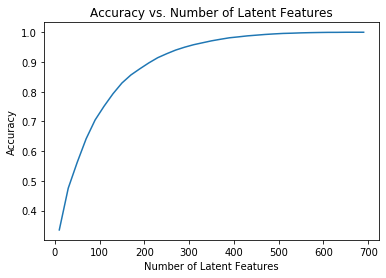

In [151]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.`  From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features.  
Using the split below: 

* How many users can we make predictions for in the test set?  
    **Answer:** 19 (no. of unique users from test set also in train set)
    
* How many users are we not able to make predictions for because of the cold start problem?  
    **Answer:** 658 (users from test set not in train set - no information on them)

* How many articles can we make predictions for in the test set?  
    **Answer:** 574 (no. of unique articles in the test set also in train set)
    
* How many articles are we not able to make predictions for because of the cold start problem?  
    **Answer:** 0 (no. of articles from test set not in train set)

In [ ]:
# compute svd on the user_item_matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [179]:
user_item_test = create_user_item_matrix(df_test)

In [249]:
def create_test_and_train_user_item(df_train, df_test):
    ''' Create user-item matrix for both train and test dataframes.
        Returns test indexes and articles along user-item matrices
        for train and test data.
    
        Args:
            df_train - (pandas dataframe) training dataframe
            df_test - (pandas dataframe) test dataframe

        Returns:
            user_item_train - a user-item matrix of the training dataframe 
                (unique users for each row and unique articles for each column)
            user_item_test - a user-item matrix of the testing dataframe 
                (unique users for each row and unique articles for each column)
            test_idx - all of the test user ids
            test_arts - all of the test article ids
    '''
    
    # create user_item matrix from train data
    user_item_train = create_user_item_matrix(df_train)
    
    # convert values in user_item to float (from int)
    user_item_train = user_item_train.astype('float')
    
    # get list of article ids in train dataframe
    train_arts = user_item_train.iloc[0,:].index.tolist()
    
    
    # create user_item matrix from train data
    user_item_test = create_user_item_matrix(df_test)
    
    # convert values in user_item to float (from int)
    user_item_test = user_item_test.astype('float')
    
    # get test user ids
    test_idx = user_item_test.index.tolist()
    
    # get test article ids
    test_arts = user_item_test.iloc[0,:].index.tolist()
    
    
    # get articles that were not part of test dataset
    articles_not_in_test = [article for article in train_arts if article not in test_arts]
    
    # append them to the original test dataframe columns
    all_test_cols = articles_not_in_test + test_arts
    
    # add columns to test dataframe, fill value is 0.0 (article not viewed)
    user_item_test = user_item_test.reindex(columns=sorted(all_test_cols), fill_value=0.0)
    
    return user_item_train, user_item_test, test_idx, test_arts

In [250]:
df_train = df.head(40000)
df_test = df.tail(5976)

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [251]:
train_users = df_train['user_id'].unique()
train_articles = df_train['article_id'].unique()

new_users = [user for user in test_idx if user not in train_users]

q1_response = len(set(test_idx).intersection(set(train_users)))
q2_response = len(new_users)

new_articles = [article for article in test_arts if article not in train_articles]

q3_response = len(set(test_arts).intersection(set(train_articles)))
q4_response = len(new_articles)

print(' > Q4.1 Answer: {}'.format(q1_response))
print(' > Q4.2 Answer: {}'.format(q2_response))
print(' > Q4.3 Answer: {}'.format(q3_response))
print(' > Q4.4 Answer: {}'.format(q4_response))

 > Q4.1 Answer: 19
 > Q4.2 Answer: 658
 > Q4.3 Answer: 574
 > Q4.4 Answer: 0


In [27]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [216]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4490, 4490), (714,), (714, 714))

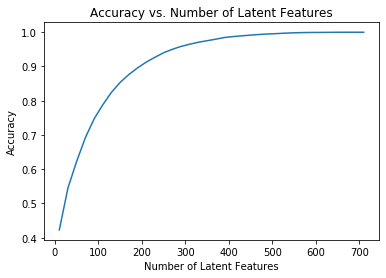

In [230]:
num_latent_feats = np.arange(10, s_train.shape[0], 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

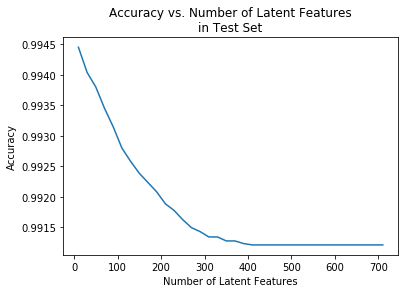

In [280]:
# get list of existing users
existing_users = list(set(test_idx).intersection(set(train_users)))

# get user location in user_item_train
user_item_existing_test_idx = user_item_train.index.get_indexer(existing_users)

# get simplified list of users to predict on
u_test = u_train[user_item_existing_test_idx, :]

num_latent_feats = np.arange(10, s_train.shape[0], 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_test[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test.loc[existing_users, :], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features\nin Test Set');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:**  
The graph above shows how accuracy decreases as we increase the number of latent features, plateauing at below 99.15% (versus 99.45% previously).  
This may be caused partially because of the very small test set, but also beacuse we may have introduced some bias by taking the last 15% of the user-item interactions (therefore selecting the newest users, whose preferences may be different from those of 'older' users).  
Finally, it seems that at around 300-400 features we have an elbow where the accuracy plateaus, so we should select a number of latent features around that area.
 
Assuming the current recommendation system is rank-based, this algorithm should improve predictions for already existing users, but it cannot be proven without a test.  
In order to prove improvement, we need to give the users a way to 'like' or 'dislike' an article, to check wether our system indeed provides better recommendations to users.

### <a class="anchor" id="Conclusions">Part VI: Extras and Conclusions</a>

Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results. These tasks are beyond what is required for this project. However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!

## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

In [28]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'IBM Watson Recommender.ipynb'])

0